In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.special as ss
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

<h1>Forward Problem</h1>

In [2]:
# size of spatial domain
L = 15.0  # originally 10, increased by 50%
# number of real space grid points (for plotting)
numx = 1025
# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32  # 32

# matrix for converting Fourier representation to real space
fournvec = np.arange(-numfour, numfour + 1) # fournvec=-nfb,...,0,...,nfb
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)
print('Shape fourtox:', fourtox.shape)

Shape fourtox: (65, 1025)


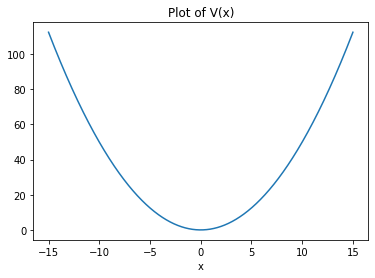

In [3]:
def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    # c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    # c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    # c8 = 4.12e-7; c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)
    # return 15 * (-np.cos(z) + np.sin((0.5 * z)**2 - 0.2 * z))
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)

# compute true potential on real space grid for plotting
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
# compute the potential operator matrix

vtoeptrue = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtoeptrue.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

vtoeptrue = jnp.array(vtoeptrue)

vmattrue = sl.toeplitz(r=vtoeptrue, c=np.conj(vtoeptrue))

print('Shape vmattrue:', vmattrue.shape)

Shape vmattrue: (65, 65)


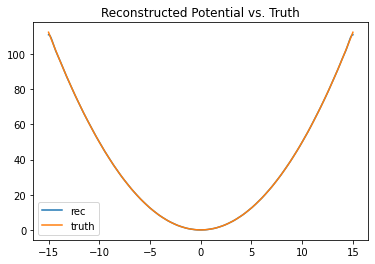

0.012198398680964392


In [5]:
# reconstruct the real space potential from the potential
# operator matrix

# at this point, "vtoeptrue" contains Fourier coefficients
# for modes 0, ..., 2*N
# let us convert this into information on modes -N, ..., N
# also we need a slight renormalization to make this a Fourier
# coefficient
# with respect to our ***orthonormal*** Fourier basis
vfour = np.sqrt(2*L)*np.concatenate([np.conjugate(np.flipud(vtoeptrue[1:(numfour + 1)])), vtoeptrue[:(numfour + 1)]])
vrecon = vfour @ fourtox

plt.plot(xvec, np.real(vfour @ fourtox), label='rec')
plt.plot(xvec, vxvec, label='truth')
plt.title('Reconstructed Potential vs. Truth')
plt.legend()
plt.show()

print(np.mean(np.square(np.abs(vrecon - vxvec))))

In [6]:
# define initial states and transform to Fourier basis

def psi0_0(x):
    return 10 * np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25

def psi0_2(x):
    return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions and transforming them to the Fourier representation

def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])

    a0 = jnp.array(a0)

    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


l2 error psi0_0: 4.200734367144785e-15
l-infinity error psi0_0: 5.551115123125783e-16
l2 error psi0_1: 3.964004819040717e-15
l-infinity error psi0_1: 5.551115123125783e-16
l2 error psi0_2: 1.7724020548838813e-05
l-infinity error psi0_2: 1.2925218408899042e-06
l2 error psi0_3: 1.7724020548838813e-05
l-infinity error psi0_3: 1.2925218408899042e-06
l2 error psi0_4: 0.0038434033141547946
l-infinity error psi0_4: 0.0015612621417012828
l2 error psi0_5: 0.003843403314154795
l-infinity error psi0_5: 0.0015612621417012828


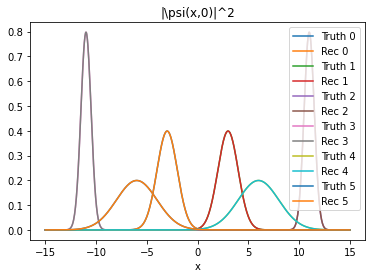

In [7]:
# compute vector of initial states

# pick initial un-normalized wave functions
psi0fnvec = [psi0_0, psi0_1, psi0_2, psi0_3, psi0_4, psi0_5]

a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)


# check if reconstructed Fourier representation is close to truth
for i in range(len(normpsi0xvec)):
    print(f'l2 error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'l-infinity error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    # plot |\psi(x,0)|^2
    plt.plot(xvec, np.abs(normpsi0xvec[i])**2, label=f"Truth {i}")
    plt.plot(xvec, np.abs(normpsi0recxvec[i])**2, label=f"Rec {i}")

plt.title('|\psi(x,0)|^2')
plt.xlabel('x')
plt.legend()
plt.show()

In [8]:
# # define initial states and transform to Fourier basis
#
# def psi0(x):
#     return np.exp(-(x + 3)**2 / 4) * (2.0 / np.pi)**0.25
#     # return np.exp(-(x - 3)**2 / 4) * (2.0 / np.pi)**0.25
#     # return np.exp(-(x - 6)**2) * (2.0 / np.pi)**0.25
#     # return np.exp(-(x + 6)**2) * (2.0 / np.pi)**0.25
#     # return np.exp(-x**2) * (2.0 / np.pi)**0.25
#
#
# # compute psi0 normalization term
# psi0_prob_intgrnd = lambda x: np.abs(psi0(x)) ** 2
# psi0_norm = np.sqrt(si.quad(psi0_prob_intgrnd, -L, L)[0])
#
# # normalized psi function (for integration)
# norm_psi0_fn = lambda x: psi0(x) / psi0_norm
#
# # compute the Fourier representation of psi0fn
# norm_psi0 = []
# for thisfourn in range (numfour + 1):
#     def intgrnd(x):
#         return norm_psi0_fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
#     def rintgrnd(x):
#         return intgrnd(x).real
#     def iintgrnd(x):
#         return intgrnd(x).imag
#     norm_psi0.append(si.quad(rintgrnd, -L, L)[0] + 1j * si.quad(iintgrnd, -L, L)[0])
#
# a0 = np.concatenate([np.conjugate(np.flipud(norm_psi0[1:])), norm_psi0])
#
# normpsi0x = norm_psi0_fn(xvec)
# normpsi0xrec = a0 @ fourtox
#
# # check if Fourier representation is close to truth
# print(f'l2 error psi0:', nl.norm(normpsi0x - normpsi0xrec))
# print(f'l-infinity error psi0:', np.max(np.abs(normpsi0x - normpsi0xrec)))
#
# # plot the real part of the normalized psi0
# plt.plot(xvec, normpsi0xrec.real, label=f"Truth")
# plt.plot(xvec, normpsi0xrec.real, label=f"Rec")
# plt.title('Real Part of Initial Wave Functions')
# plt.xlabel('x')
# plt.legend()
# plt.show()

---
**Forward Propagation**

In [9]:
# Eigendecomposition of Hamiltonian

# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
9.770256348336455e-13
stttrue unitary check (should be close to zero):
1.9640078542463594e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


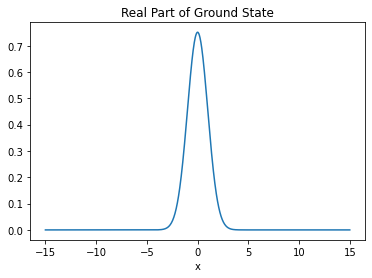

Quick normalization check (should be close to 1):
1.0000000000000022
Accurate normalization check (should be close to 1):
1.0000000000000022


In [10]:
# plot ground state of Eigendecomposition

# find indices that sort eigenvalues
ordering = jnp.argsort(spctrue)

# print the first few eigenvalues
print(spctrue[ordering[:6]])

# pick out and plot real part of the ground state
groundstate = ordering[0]
wavefn = stttrue[:, groundstate] @ fourtox
plt.plot(xvec, np.real(wavefn))
plt.title('Real Part of Ground State')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick normalization check (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Accurate normalization check (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

In [11]:
# Propagate

# set time-step size
dt = 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 20  # 40  # 100

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T

amattruevec = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for i in range(numts):
        tempamat.append(propatrue @ tempamat[-1])

    amattruevec.append(tempamat)


amattruevec = jnp.array(amattruevec)

print('Shape amattrue:', amattruevec.shape)

print('Done propagating')

Shape amattrue: (6, 21, 65)
Done propagating


In [12]:
# # Propagate
#
# # set time-step size
# dt = 1e-2
#
# # set number of time steps
# # trajectory length is numts + 1 (initial state + numts steps)
# numts = 40
#
# # compute propagator matrix
# propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T
#
# # propagate system starting from initial "a" state
# amattrue = [jnp.array(a0)]
# for i in range(numts):
#     amattrue.append(propatrue @ amattrue[-1])
#
# amattrue = jnp.array(amattrue)
#
# print('Shape amattrue:', amattrue.shape)
#
# print('Done propagating')

In [13]:
# check if system's state remains normalized for the propagation

psimattruevec = amattruevec @ fourtox
print('Shape psimattrue:', psimattruevec.shape)

probmattruevec = np.abs(psimattruevec) ** 2
print('Shape probmattrue:', probmattruevec.shape)

normmattruevec = si.trapezoid(probmattruevec, xvec)
print('Shape normmattrue:', normmattruevec.shape)

# average deviation from 1
np.mean(np.abs(normmattruevec - 1.0))

Shape psimattrue: (6, 21, 1025)
Shape probmattrue: (6, 21, 1025)
Shape normmattrue: (6, 21)


1.2366530776392842e-07

---
<h1>Inverse Problem</h1>

In [14]:
# code for constructing a toeplitz matrix from the
# Fourier representation
# flat_toep_vec = jnp.concatenate([jnp.flipud(cvrow.conj()), cvrow[1:]])

numtoepelms = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = np.array(aa + bb)
print(toepindxmat.shape)

(65, 65)


In [15]:
# check if index method makes same vmat
# should be close to 0

print(nl.norm(vmattrue - np.concatenate([np.flipud(np.conj(vtoeptrue)), vtoeptrue[1:]])[toepindxmat]))

0.0


In [16]:
# amplitude squared training data
# we need |\psi(t)|^2 in the Fourier representation

# compute "beta" from "a"
# correlate only works with 1D vectors
betamattruevec = []
for thisamat in amattruevec:
    tempbetamat = []
    for thisavec in thisamat:
        tempbetamat.append(jnp.correlate(thisavec, thisavec, 'same'))

    betamattruevec.append(jnp.array(tempbetamat))

betamattruevec = jnp.array(betamattruevec) / jnp.sqrt(2 * L)


print('Shape betamattruevec:', betamattruevec.shape)
print('Shape probmattruevec:', probmattruevec.shape)

probmatrecvec = betamattruevec @ fourtox
print('Shape betamattruevec @ fourtox:', probmatrecvec.shape)

print('l2 error betamattruevec:', jnl.norm(probmattruevec - probmatrecvec))
print('l-inf error betamattruevec:', jnp.max(jnp.abs((probmattruevec - probmatrecvec))))

Shape betamattruevec: (6, 21, 65)
Shape probmattruevec: (6, 21, 1025)
Shape betamattruevec @ fourtox: (6, 21, 1025)
l2 error betamattruevec: 0.027974350843802336
l-inf error betamattruevec: 0.0005240240595842938


In [17]:
# # amplitude squared training data
# # we need |\psi(t)|^2 in the Fourier representation
#
# # compute "beta" from "a"
# # np.convolve only works with 1D vectors
# betamattrue = []
# for thisavec in amattruevec[0]:
#     betamattrue.append(np.convolve(thisavec.conj(), np.flip(thisavec), 'same').conj())
#
# betamattrue = jnp.array(betamattrue) / jnp.sqrt(2 * L)
#
# batamattest = []
# for thisavec in amattruevec[0]:
#     batamattest.append(jnp.correlate(thisavec, thisavec, 'same'))
#
# batamattest = jnp.array(batamattest) / jnp.sqrt(2 * L)
#
# print(batamattest.shape)
#
# print('Shape probmattrue', probmattruevec[0].shape)
# print('Shape betamattrue', betamattrue.shape)
# print('Shape betamattrue @ fourtox:', np.shape(betamattrue @ fourtox))
#
# print('l2 norm betamattrue & batamattest:', nl.norm(betamattrue - batamattest))
#
# print('l2 error betamattrue:', nl.norm(probmattruevec[0] - betamattrue @ fourtox))
#
# print('l2 error batamattest:', nl.norm(probmattruevec[0] - batamattest @ fourtox))

In [18]:
type(betamattruevec)

jaxlib.xla_extension.DeviceArray

In [19]:
# objective function

def probobj(theta, verbose=False):
    # put learning parameters into complex toeplitz vector form
    # vtoephat = theta[:2 * numfour + 1] + 1j * jnp.concatenate((jnp.array([0.0]), theta[2 * numfour + 2:]))
    vtoephat = theta[:2 * numfour + 1] + 1j * theta[2 * numfour + 1:]

    if verbose:
        print('l2 error vtoephat:', jnl.norm(vtoephat - vtoeptrue))

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    if verbose:
        # check if hmat is Hermitian
        print('hmat hermitian? (should be close to 0):', jnl.norm(hmathat - hmathat.T.conj()), sep='\n')
        print('l2 error hmat:', jnl.norm(hmathat - hmattrue))

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    if verbose:
        # check if the decomposition diagonalizes hmat
        # if this is close to zero then
        # hmat = states @ np.diag(spec) @ np.conj(states).T
        print('hmathat diagonalized? (should be close to 0):', jnl.norm(hmathat @ stthat - stthat @ jnp.diag(spchat)), sep='\n')

        # check if stt is unitary
        print('stthat unitary? (should be close to 0):', jnl.norm(stthat @ stthat.T.conj() - jnp.eye(2 * numfour + 1)), sep='\n')

        print('l2 error spchat:', jnl.norm(spchat - spctrue))
        print('l2 error stthat:', jnl.norm(stthat - stttrue))

        print('|| vmattrue - vmathat || = ', jnl.norm(vmattrue - vmathat))

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    rtnobj = 0.0
    for r in range(len(a0vec)):
        thisa0 = a0vec[r]
        thisavec = thisa0.copy()
        temprhomat = [jnp.correlate(thisa0, thisa0, 'same') / jnp.sqrt(2 * L)]

        if verbose:
            print('')
            print('l2 error thisavec:', jnl.norm(thisavec - amattruevec[r, 0]))
            print('l2 error tempbetamat[-1]:', jnl.norm(temprhomat[-1] - betamattruevec[r, 0]))

        # propagate system starting from initial "a" state
        for i in range(numts):
            # propagate the system one time-step
            thisavec = (propahat @ thisavec)

            # calculate the amp^2
            temprhomat.append(jnp.correlate(thisavec, thisavec, 'same') / jnp.sqrt(2 * L))

            if verbose:
                # if i % 1 == 0:
                if i % 10 == 0:
                    print('l2 error thisavec:', jnl.norm(thisavec - amattruevec[r, i+1]))
                    print('l2 error tempbetamat[-1]:', jnl.norm(temprhomat[-1] - betamattruevec[r, i+1]))

        # compute objective functions
        tempresid = jnp.array(temprhomat) - betamattruevec[r]
        thisobj = 0.5 * jnp.sum(jnp.abs(tempresid)**2)

        rtnobj += thisobj

        if verbose:
            print('')
            print('Shape tempbetamat:', jnp.shape(temprhomat))
            print('l2 error tempbetamat:', jnl.norm(tempresid))
            print('thisobj:', thisobj)
            print('')

    return rtnobj

In [20]:
# true potential in a form that can be tested in objective

vtoeptruecat = jnp.concatenate((jnp.real(vtoeptrue), jnp.concatenate((jnp.array([0.0]), jnp.imag(vtoeptrue[1:])))))

print('Shape vfourcat:', vtoeptruecat.shape)

print(nl.norm(vtoeptruecat[:2 * numfour + 1] + 1j * vtoeptruecat[2 * numfour + 1:] - vtoeptrue))

Shape vfourcat: (130,)
0.0


In [21]:
# check objective with true potential
print('Objective:', probobj(vtoeptruecat, verbose=True))

l2 error vtoephat: 0.0
hmat hermitian? (should be close to 0):
0.0
l2 error hmat: 0.0
hmathat diagonalized? (should be close to 0):
9.770256348336455e-13
stthat unitary? (should be close to 0):
1.9640078542463594e-14
l2 error spchat: 0.0
l2 error stthat: 0.0
|| vmattrue - vmathat || =  0.0

l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0

Shape tempbetamat: (21, 65)
l2 error tempbetamat: 0.0
thisobj: 0.0


l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0

Shape tempbetamat: (21, 65)
l2 error tempbetamat: 0.0
thisobj: 0.0


l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0

Shape tempbetamat: (21, 65)
l2 error tempbetamat: 0.0
thisobj: 0.0


l2 error thisavec: 0.

In [22]:
# jit probobj
jitprobobj = jax.jit(probobj)

In [23]:
# complie and test jitprobobj
print(jitprobobj(vtoeptruecat))

2.1597678807356905e-31


In [24]:
# JAX grad of the objective
gradprobobj = jax.jit(jax.grad(jitprobobj))

In [25]:
# check grad of objective with true potential
print(jnl.norm(gradprobobj(vtoeptruecat)))

1.1704661242187232e-16


---
**Initialize with perturbed true coefficients**

In [26]:
seed = 1234  # set to None for random initialization
thetatrub = vtoeptruecat.copy()
thetatrub += 2 * np.random.default_rng(seed).normal(size=len(thetatrub))
# thetatrub += 0.25 * np.random.default_rng(seed).normal(size=len(thetatrub))

thetatrub = jnp.array(thetatrub)

In [27]:
print(jitprobobj(thetatrub))
print(nl.norm(gradprobobj(thetatrub)))

5.308311686624087
1.0333138321887445


In [ ]:
rslttrubjaxgrad = so.minimize(jitprobobj, thetatrub, jac=gradprobobj, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x

# rslttrubjaxgrad = so.minimize(jitprobobj, thetatrub, jac=gradprobobj, options={'maxiter': 2000, 'disp': True}).x

# rslttrubjaxgrad = so.minimize(jitprobobj, vtoeptruecat, jac=gradprobobj, tol=1e-12, options={'maxiter': 3000, 'disp': True, 'gtol': 1e-15}).x

In [ ]:
print(jitprobobj(rslttrubjaxgrad))
print(nl.norm(gradprobobj(rslttrubjaxgrad)))

In [ ]:
fourvtoeplearn = rslttrubjaxgrad[:2 * numfour + 1] + 1j*rslttrubjaxgrad[2 * numfour + 1:]
print(nl.norm(fourvtoeplearn - vtoeptrue))
print(np.max(np.abs(fourvtoeplearn - vtoeptrue)))

In [ ]:
# plot learned vs true
cmpcfftrub = thetatrub[:2 * numfour + 1] + 1j * thetatrub[2 * numfour + 1:]
# cmpcfftrub = thetatrub[:2 * numfour + 1] + 1j*np.concatenate(([0.0], thetatrub[2 * numfour + 1:]))

cmprslttrubgrad = rslttrubjaxgrad[:2 * numfour + 1] + 1j * rslttrubjaxgrad[2 * numfour + 1:]
# cmprslttrubgrad = rslttrubjaxgrad[:2 * numfour + 1] + 1j*np.concatenate(([0.0], rslttrubjaxgrad[2 * numfour + 1:]))

plt.plot(np.real(cmprslttrubgrad), '.-', label='learned')
# plt.plot(xvec, np.real(cmpcfftrub @ fourtox), label='init')
plt.plot(np.real(vtoeptrue), label='truth')
# plt.plot(xvec, vxvec, label='real truth')
plt.title('Learned theta vs. Truth')
plt.legend()
plt.show()

plt.plot(np.imag(cmprslttrubgrad), '.-', label='learned')
# plt.plot(xvec, np.real(cmpcfftrub @ fourtox), label='init')
plt.plot(np.imag(vtoeptrue), label='truth')
# plt.plot(xvec, vxvec, label='real truth')
plt.title('Learned theta vs. Truth')
plt.legend()
plt.show()

In [ ]:
vfour = np.sqrt(2*L) * np.concatenate([np.conjugate(np.flipud(cmprslttrubgrad[1:(numfour+1)])), cmprslttrubgrad[:(numfour+1)]])
vrecon = vfour @ fourtox

vicfour = np.sqrt(2*L) * np.concatenate([np.conjugate(np.flipud(cmpcfftrub[1:(numfour+1)])), cmpcfftrub[:(numfour+1)]])
vic = vicfour @ fourtox

plt.plot(xvec, jnp.real(vrecon), color='red')
plt.plot(xvec, vxvec, color='black')
plt.plot(xvec, jnp.real(vic), color='green')
plt.show()

---
**Initialize with random coefficients**

In [ ]:
seed = 1234  # set to None for random initialization
# thetarnd = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=vtoeptruecat.shape)
thetarnd = 0.001 * np.random.default_rng(seed).normal(size=vtoeptruecat.shape)
# thetarnd = np.random.default_rng(seed).uniform(low=-0.001, high=0.001, size=vtoeptruecat.shape)

thetarnd = jnp.array(thetarnd)

In [ ]:
rsltrndjaxgrad = so.minimize(jitprobobj, thetarnd, jac=gradprobobj, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x

In [ ]:
print(jitprobobj(rsltrndjaxgrad))
print(nl.norm(gradprobobj(rsltrndjaxgrad)))

In [ ]:
fourvtoeplearnrnd = rsltrndjaxgrad[:2 * numfour + 1] + 1j*rsltrndjaxgrad[2 * numfour + 1:]
print(nl.norm(fourvtoeplearnrnd - vtoeptrue))
print(np.max(np.abs(fourvtoeplearnrnd - vtoeptrue)))

In [ ]:
# plot learned vs true
cmpcffrnd = thetarnd[:2 * numfour + 1] + 1j * thetarnd[2 * numfour + 1:]
# cmpcfftrub = thetatrub[:2 * numfour + 1] + 1j*np.concatenate(([0.0], thetatrub[2 * numfour + 1:]))

cmprsltrndjaxgrad = rsltrndjaxgrad[:2 * numfour + 1] + 1j*rsltrndjaxgrad[2 * numfour + 1:]
# cmprslttrubgrad = rslttrubjaxgrad[:2 * numfour + 1] + 1j*np.concatenate(([0.0], rslttrubjaxgrad[2 * numfour + 1:]))

plt.plot(np.real(cmprsltrndjaxgrad), '.-', label='learned')
# plt.plot(xvec, np.real(cmpcfftrub @ fourtox), label='init')
plt.plot(np.real(vtoeptrue), label='truth')
# plt.plot(xvec, vxvec, label='real truth')
plt.title('Learned theta vs. Truth')
plt.legend()
plt.show()

plt.plot(np.imag(cmprsltrndjaxgrad), '.-', label='learned')
# plt.plot(xvec, np.real(cmpcfftrub @ fourtox), label='init')
plt.plot(np.imag(vtoeptrue), label='truth')
# plt.plot(xvec, vxvec, label='real truth')
plt.title('Learned theta vs. Truth')
plt.legend()
plt.show()

In [ ]:
vfour = np.sqrt(2*L) * np.concatenate([np.conjugate(np.flipud(cmprsltrndjaxgrad[1:(numfour+1)])), cmprsltrndjaxgrad[:(numfour+1)]])
vrecon = vfour @ fourtox

vicfour = np.sqrt(2*L) * np.concatenate([np.conjugate(np.flipud(cmpcffrnd[1:(numfour+1)])), cmpcffrnd[:(numfour+1)]])
vic = vicfour @ fourtox

plt.plot(xvec, jnp.real(vrecon), '.-', label='Learned')
plt.plot(xvec, vxvec, label='Truth')
# plt.plot(xvec, jnp.real(vic), color='green')
plt.xlabel('x')
plt.title('True Potential vs. Learned Potential')
plt.show()

In [ ]:
zeroindex = len(xvec) // 2
print(xvec[zeroindex])

print(xvec[125])

diff = vxvec[zeroindex] - jnp.real(vrecon)[zeroindex]

plt.plot(xvec, jnp.real(vrecon) + diff, '.', color='red')
plt.plot(xvec, vxvec, color='black')
plt.plot(xvec, jnp.real(vic), color='green')
plt.show()

print(nl.norm(jnp.real(vrecon) + diff - vxvec))
print('l2 error:', nl.norm(jnp.real(vrecon)[125:-125] + diff - vxvec[125:-125]))
print(np.mean(np.abs(jnp.real(vrecon)[125:-125] + diff - vxvec[125:-125])))

---
<h1>Adjoint Method</h1>

\begin{equation*}
%
\rho_j^r
& = \frac{1}{\sqrt{2 L}} \sum_{k=-F}^F a_{k + j}^r \overline{a}_k^r
%
\end{equation*}

``rho = [jnp.correlate(thisa0, thisa0, 'same') / jnp.sqrt(2 * L)]``


\begin{equation*}
%
M_{j, \ell}^r = \overline{a_{\ell - j}^r}
%
\end{equation*}

\begin{equation*}
%
P_{j, \ell}^r = a_{\ell + j}^r
%
\end{equation*}

In [ ]:
def mk_M_and_P(avec):
    halflen = len(avec) // 2
    padavec = jnp.concatenate((jnp.zeros(halflen), jnp.array(avec), jnp.zeros(halflen)))

    rawmat = []
    for j in range(2 * halflen + 1):
        rawmat.append(padavec[2 * halflen - j:4 * halflen + 1 - j])

    Mmat = jnp.conjugate(jnp.array(rawmat))
    Pmat = jnp.flipud(jnp.array(rawmat))

    return Mmat, Pmat

In [ ]:
jit_mk_M_and_P = jax.jit(mk_M_and_P)

In [ ]:
# direct computation of sum to check if M and P
# matrices are correct

# testa = [1, 2, 3, 4, 5]  # [1 + 0.5j, 2 + 1.0j, 3 + 1.5j, 4 + 2.0j, 5 + 2.5j]
#
# testM, testP = jit_mk_M_and_P(testa)
# print('M:', testM, 'P:', testP, sep='\n')
#
# # print(testM + testP)
# print(np.sum(testM + testP, axis=1))

# testhalflen = len(testa) // 2
# testdeltavec = []
# for j in np.arange(-testhalflen, testhalflen+1):
#     thissum = 0
#     for ell in np.arange(-testhalflen, testhalflen+1):
#         # print('j:', j)
#         # print('ell:', ell)
#         if np.abs(ell-j) > testhalflen:
#             am = 0
#         else:
#             am = testa[testhalflen + ell - j]
#         if np.abs(ell+j) > testhalflen:
#             ap = 0
#         else:
#             ap = testa[testhalflen + ell + j]
#
#         # print('am:', am)
#         # print('ap:', ap)
#         thissum += np.conjugate(am) + ap
#
#     testdeltavec.append(thissum)
#
# print(testdeltavec)
#
# # print(testM + testP)
# print(np.sum(testM + testP, axis=1))

---

\begin{equation*}
%
\lambda^T
= \frac{1}{\sqrt{2 L}} \left[ \left( M^T \right)^\dagger \left( \rho^T - \beta^T \right) + \overline{\left( P^T \right)^\dagger \left( \rho^T - \beta^T \right)} \right]
%
\end{equation*}

\begin{equation*}
%
\lambda^r
= \frac{1}{\sqrt{2 L}} \left[ \left( M^r \right)^\dagger \left( \rho^r - \beta^r \right) + \overline{\left( P^r \right)^\dagger \left( \rho^r - \beta^r \right)} \right] +
\left[ e^{ -i \hat{H} \Delta t} \right]^\dagger \lambda^{r+1}
%
\end{equation*}

\begin{equation*}
%
\frac{\partial L}{\partial \hat{\theta}}
= \mathfrak{R}
\left< \lambda^{r+1},
\left. \frac{\partial}{\partial \Upsilon} e^\Upsilon \right|_{\Upsilon = -i \hat{H} \Delta t}
\left( -i \Delta t \right) \hat{a}^r
\right>
= \mathfrak{R} - \sum_{r=0}^{T-1}
\left( \lambda^{r+1} \right)^\dagger
\left. \frac{\partial}{\partial \Upsilon} e^\Upsilon \right|_{\Upsilon = -i \hat{H} \Delta t}
\left( -i \Delta t \right) \hat{a}^r
%
\end{equation*}

In [ ]:
def adjgrads(theta):
    # to use theta we need to first recombine the real
    # and imaginary parts into a vector of complex values
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    # vtoephatI = theta[numtoepelms:]
    vtoephat = vtoephatR + 1j * vtoephatI
    # print('Shape vtoephat:', vtoephat.shape)

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # forward propagation
    ahatmatvec = []
    rhomatvec = []
    lammatvec = []
    for r in range(len(a0vec)):
        thisahatmat = [a0vec[r].copy()]

        # propagate system starting from initial "a" state
        thisrhomat = [jnp.correlate(thisahatmat[0], thisahatmat[0], 'same') / jnp.sqrt(2 * L)]
        thispartlammat = [jnp.zeros(numtoepelms, dtype=complex)]
        for i in range(numts):
            # propagate the system one time-step
            thisahatmat.append(propahat @ thisahatmat[-1])

            # calculate the amp^2
            thisrhomat.append(jnp.correlate(thisahatmat[-1], thisahatmat[-1], 'same') / jnp.sqrt(2 * L))

            # compute \rho^r - \beta^r
            thiserr = thisrhomat[-1] - thisrhomat[i+1]

            # compute M and P matrix for lambda mat
            thisMmat, thisPmat = jit_mk_M_and_P(thisahatmat[-1])

            # compute part of lambda mat
            # ( 1 / \sqrt{2 L} ) * [ ( M^r )^\dagger * ( \rho^r - \beta^r )
            # + \overline{( P^r )^\dagger * ( \rho^r - \beta^r )} ]
            thispartlammat.append((thisMmat.conj().T @ thiserr + (thisPmat.conj().T @ thiserr).conj()) / jnp.sqrt(2 * L))

        ahatmatvec.append(jnp.array(thisahatmat))

        # build lammat backwards then flip at the end
        thislammat = [thispartlammat[-1]]
        for i in range(2, numts + 2):
            thislammat.append(thispartlammat[-i] + proplam @ thislammat[-1])

        lammatvec.append(jnp.flipud(jnp.array(thislammat)))



    #######################################
    # the remainder of this function is for computing the
    # gradient of the exponential matrix
    #######################################

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    myeye = jnp.eye(numtoepelms)
    wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmatsR = wsR[toepindxmat]
    prederivamatR = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, ctrmatsR,stthat)
    derivamatR = prederivamatR * jnp.expand_dims(mask,2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatR, stthat.conj().T)

    wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:,1:]])
    wsI = wsI[1:,:]
    wsI = wsI.T
    ctrmatsI = wsI[toepindxmat]
    prederivamatI = jnp.einsum('ij,jkm,kl->ilm',stthat.conj().T, ctrmatsI, stthat)
    derivamatI = prederivamatI * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatI, stthat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])


    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lammatvec[0][1:,:]), alldmat, ahatmatvec[0][:-1,:]))
    for i in range(1, len(lammatvec)):
        gradients += jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lammatvec[i][1:,:]), alldmat, ahatmatvec[i][:-1,:]))

    return gradients

---
* Forward Problem
    * Computational Variables
    * Potential (real space and Fourier basis)
    * Initial wave function (real and Fourier)
    * Solution to forward problem
* Inverse Problem
    * Training data (prob density - new)
    * Objective (new)
    * JAX grad of objective
    * Solver (optimizer)